In [6]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
from tqdm import tqdm

# ========== 🔧 CONFIG ==========
debug_mode = True         # ⬅️ Toggle this OFF for full training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data_dir = 'E:/final project/Dataset/New Plant Diseases Dataset'
batch_size = 32
num_epochs = 15
patience = 5

# ========== 🖼️ TRANSFORMS ==========
image_size = 128 if debug_mode else 256  # ⬅️ Smaller images in debug mode

transform_train = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

transform_test = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# ========== 📂 LOAD DATA ==========
train_dataset = datasets.ImageFolder(root=os.path.join(data_dir, 'train'), transform=transform_train)
valid_dataset = datasets.ImageFolder(root=os.path.join(data_dir, 'valid'), transform=transform_test)

# 🐛 DEBUG MODE: use subset
if debug_mode:
    train_dataset = Subset(train_dataset, range(2000))
    valid_dataset = Subset(valid_dataset, range(500))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# 🏷️ Class count
num_classes = len(datasets.ImageFolder(root=os.path.join(data_dir, 'train')).classes)

# ========== 🧠 MODEL ==========
class AdvancedPlantDiseaseCNN(nn.Module):
    def __init__(self, num_classes):
        super(AdvancedPlantDiseaseCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(), nn.BatchNorm2d(32),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.BatchNorm2d(64),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.BatchNorm2d(128),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(128, 256, 3, padding=1), nn.ReLU(), nn.BatchNorm2d(256),
            nn.AdaptiveAvgPool2d((1, 1))
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256, 128), nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

model = AdvancedPlantDiseaseCNN(num_classes).to(device)

# ========== 🎯 LOSS & OPTIMIZER ==========
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

# ========== 🔁 TRAINING LOOP ==========
best_val_acc = 0
counter = 0

for epoch in range(num_epochs):
    model.train()
    train_correct, train_total, train_loss = 0, 0, 0

    for images, labels in tqdm(train_loader, desc=f"Training Epoch {epoch+1}"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        train_correct += (preds == labels).sum().item()
        train_total += labels.size(0)

    train_acc = 100 * train_correct / train_total
    avg_train_loss = train_loss / len(train_loader)

    # ===== Validation =====
    model.eval()
    val_correct, val_total, val_loss = 0, 0, 0
    with torch.no_grad():
        for images, labels in tqdm(valid_loader, desc=f"Validating Epoch {epoch+1}"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_acc = 100 * val_correct / val_total
    avg_val_loss = val_loss / len(valid_loader)
    scheduler.step(avg_val_loss)

    print(f"\n📘 Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.2f}% | "
          f"Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.2f}%")

    # ========== EARLY STOPPING ==========
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_custom_cnn.pth")
        print("✅ New best model saved.")
        counter = 0
    else:
        counter += 1
        print(f"⏳ No improvement. Patience counter: {counter}/{patience}")
        if counter >= patience:
            print("⛔ Early stopping triggered.")
            break


Validating Epoch 1: 100%|██████████| 16/16 [00:15<00:00,  1.06it/s]



📘 Epoch 1/15 | Train Loss: 0.9828 | Train Acc: 93.15% | Val Loss: 0.0671 | Val Acc: 100.00%
✅ New best model saved.


Validating Epoch 2: 100%|██████████| 16/16 [00:14<00:00,  1.12it/s]



📘 Epoch 2/15 | Train Loss: 0.0579 | Train Acc: 99.95% | Val Loss: 0.0023 | Val Acc: 100.00%
⏳ No improvement. Patience counter: 1/5


Validating Epoch 3: 100%|██████████| 16/16 [00:17<00:00,  1.07s/it]



📘 Epoch 3/15 | Train Loss: 0.0164 | Train Acc: 100.00% | Val Loss: 0.0059 | Val Acc: 100.00%
⏳ No improvement. Patience counter: 2/5


Validating Epoch 4: 100%|██████████| 16/16 [00:14<00:00,  1.07it/s]



📘 Epoch 4/15 | Train Loss: 0.0103 | Train Acc: 100.00% | Val Loss: 0.0029 | Val Acc: 100.00%
⏳ No improvement. Patience counter: 3/5


Validating Epoch 5: 100%|██████████| 16/16 [00:13<00:00,  1.16it/s]



📘 Epoch 5/15 | Train Loss: 0.0031 | Train Acc: 100.00% | Val Loss: 0.0001 | Val Acc: 100.00%
⏳ No improvement. Patience counter: 4/5


Validating Epoch 6: 100%|██████████| 16/16 [00:15<00:00,  1.05it/s]


📘 Epoch 6/15 | Train Loss: 0.0032 | Train Acc: 99.95% | Val Loss: 0.0001 | Val Acc: 100.00%
⏳ No improvement. Patience counter: 5/5
⛔ Early stopping triggered.


In [7]:
import torch
import torch.nn as nn
from tqdm import tqdm
import matplotlib.pyplot as plt

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the best model architecture again (if needed)
model = AdvancedPlantDiseaseCNN(num_classes=num_classes).to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2)

# Early stopping + training tracking
best_val_acc = 0
patience = 5
counter = 0
num_epochs = 15

# Track metrics
train_acc_history = []
val_acc_history = []
train_loss_history = []
val_loss_history = []

# ------------------------ Training Loop ------------------------
for epoch in range(num_epochs):
    model.train()
    train_correct, train_total, train_loss = 0, 0, 0

    for images, labels in tqdm(train_loader, desc=f"Training Epoch {epoch+1}"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        train_correct += (preds == labels).sum().item()
        train_total += labels.size(0)

    train_acc = 100 * train_correct / train_total
    avg_train_loss = train_loss / len(train_loader)

    # Validation
    model.eval()
    val_correct, val_total, val_loss = 0, 0, 0
    with torch.no_grad():
        for images, labels in tqdm(valid_loader, desc=f"Validating Epoch {epoch+1}"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_acc = 100 * val_correct / val_total
    avg_val_loss = val_loss / len(valid_loader)

    scheduler.step(avg_val_loss)

    print(f"\n📘 Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.2f}% | "
          f"Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.2f}%")

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_custom_cnn_2.pth")
        print("✅ New best model saved.")
        counter = 0
    else:
        counter += 1
        print(f"⏳ No improvement. Patience counter: {counter}/{patience}")
        if counter >= patience:
            print("⛔ Early stopping triggered.")
            break

    # Track history
    train_acc_history.append(train_acc)
    val_acc_history.append(val_acc)
    train_loss_history.append(avg_train_loss)
    val_loss_history.append(avg_val_loss)


from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define test data transform (same as training/validation)
test_transform = transforms.Compose([
    transforms.Resize((128, 128)),  # adjust based on your model input size
    transforms.ToTensor(),
])

# Define test dataset and loader
test_dataset = datasets.ImageFolder(root="data/test", transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


# ------------------------ Test Set Evaluation ------------------------

print("\n🔍 Evaluating best model on test set...")
model.load_state_dict(torch.load("best_custom_cnn_2.pth"))
model.eval()

test_correct, test_total, test_loss = 0, 0, 0

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Testing"):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        test_correct += (preds == labels).sum().item()
        test_total += labels.size(0)

test_acc = 100 * test_correct / test_total
avg_test_loss = test_loss / len(test_loader)

print(f"\n🧪 Test Accuracy: {test_acc:.2f}% | Test Loss: {avg_test_loss:.4f}")

# ------------------------ Accuracy & Loss Plots ------------------------

epochs = range(1, len(train_acc_history) + 1)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc_history, label='Train Accuracy')
plt.plot(epochs, val_acc_history, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training vs Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss_history, label='Train Loss')
plt.plot(epochs, val_loss_history, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()


Validating Epoch 1: 100%|██████████| 16/16 [00:17<00:00,  1.09s/it]



📘 Epoch 1/15 | Train Loss: 0.6294 | Train Acc: 94.30% | Val Loss: 0.0146 | Val Acc: 100.00%
✅ New best model saved.


Validating Epoch 2: 100%|██████████| 16/16 [00:16<00:00,  1.05s/it]



📘 Epoch 2/15 | Train Loss: 0.0103 | Train Acc: 100.00% | Val Loss: 0.0004 | Val Acc: 100.00%
⏳ No improvement. Patience counter: 1/5


Validating Epoch 3: 100%|██████████| 16/16 [00:15<00:00,  1.03it/s]



📘 Epoch 3/15 | Train Loss: 0.0072 | Train Acc: 100.00% | Val Loss: 0.0140 | Val Acc: 100.00%
⏳ No improvement. Patience counter: 2/5


Validating Epoch 4: 100%|██████████| 16/16 [00:16<00:00,  1.03s/it]



📘 Epoch 4/15 | Train Loss: 0.0053 | Train Acc: 100.00% | Val Loss: 0.0002 | Val Acc: 100.00%
⏳ No improvement. Patience counter: 3/5


Validating Epoch 5: 100%|██████████| 16/16 [00:15<00:00,  1.07it/s]



📘 Epoch 5/15 | Train Loss: 0.0071 | Train Acc: 100.00% | Val Loss: 0.0020 | Val Acc: 100.00%
⏳ No improvement. Patience counter: 4/5


Validating Epoch 6: 100%|██████████| 16/16 [00:14<00:00,  1.09it/s]


📘 Epoch 6/15 | Train Loss: 0.0004 | Train Acc: 100.00% | Val Loss: 0.0000 | Val Acc: 100.00%
⏳ No improvement. Patience counter: 5/5
⛔ Early stopping triggered.


FileNotFoundError: [WinError 3] The system cannot find the path specified: 'data/test'

In [ ]:
# ========== 📂 LOAD TEST DATA ==========
test_dataset = datasets.ImageFolder(root=os.path.join(data_dir, 'test'), transform=transform_test)
if debug_mode:
    test_dataset = Subset(test_dataset, range(500))

test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)


In [8]:
import os
import shutil
from pathlib import Path

# Source: flat folder with test images
source_dir = r"E:\final project\Dataset\New Plant Diseases Dataset\test\test"

# Destination: where to create subfolders per class
destination_dir = r"E:\final project\Dataset\New Plant Diseases Dataset\test\organized"

# Create destination root if it doesn't exist
os.makedirs(destination_dir, exist_ok=True)

# Loop over all images in the source directory
for filename in os.listdir(source_dir):
    if filename.lower().endswith((".jpg", ".jpeg", ".png")):
        # Extract class name from filename (everything before the first digit)
        class_name = ''.join(filter(str.isalpha, filename))
        class_folder = os.path.join(destination_dir, class_name)
        os.makedirs(class_folder, exist_ok=True)

        # Source and target file paths
        src_path = os.path.join(source_dir, filename)
        dst_path = os.path.join(class_folder, filename)

        # Move or copy the image
        shutil.copy2(src_path, dst_path)  # use shutil.move if you prefer

print("✅ Test dataset reorganized successfully!")


✅ Test dataset reorganized successfully!


In [ ]:
import os
import torch
import torch.nn as nn
from tqdm import tqdm
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from model import AdvancedPlantDiseaseCNN  # Ensure your model is defined here

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Parameters
num_classes = 38  # Change as per your dataset
num_epochs = 15
patience = 5
learning_rate = 0.001
batch_size = 32

# Data transforms
data_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

# Load data
train_loader = DataLoader(
    datasets.ImageFolder("data/train", transform=data_transform),
    batch_size=batch_size, shuffle=True
)

valid_loader = DataLoader(
    datasets.ImageFolder("data/valid", transform=data_transform),
    batch_size=batch_size, shuffle=False
)

test_loader = DataLoader(
    datasets.ImageFolder(
        r"E:/final project/Dataset/New Plant Diseases Dataset/test/organized",
        transform=data_transform
    ),
    batch_size=batch_size, shuffle=False
)

# Model, Loss, Optimizer, Scheduler
model = AdvancedPlantDiseaseCNN(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2)

# Tracking metrics
best_val_acc = 0
counter = 0
train_acc_history, val_acc_history = [], []
train_loss_history, val_loss_history = [], []

# ------------------------ Training Loop ------------------------
for epoch in range(num_epochs):
    model.train()
    train_loss, train_correct, train_total = 0, 0, 0

    for images, labels in tqdm(train_loader, desc=f"Training Epoch {epoch+1}"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        train_correct += (preds == labels).sum().item()
        train_total += labels.size(0)

    avg_train_loss = train_loss / len(train_loader)
    train_acc = 100 * train_correct / train_total

    # Validation
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for images, labels in tqdm(valid_loader, desc=f"Validating Epoch {epoch+1}"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    avg_val_loss = val_loss / len(valid_loader)
    val_acc = 100 * val_correct / val_total

    scheduler.step(avg_val_loss)

    print(f"\n📘 Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.2f}% | "
          f"Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.2f}%")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_custom_cnn.pth")
        print("✅ New best model saved.")
        counter = 0
    else:
        counter += 1
        print(f"⏳ No improvement. Patience counter: {counter}/{patience}")
        if counter >= patience:
            print("⛔ Early stopping triggered.")
            break

    # Save metrics
    train_acc_history.append(train_acc)
    val_acc_history.append(val_acc)
    train_loss_history.append(avg_train_loss)
    val_loss_history.append(avg_val_loss)

# ------------------------ Test Set Evaluation ------------------------
print("\n🔍 Evaluating best model on test set...")
model.load_state_dict(torch.load("best_custom_cnn.pth"))
model.eval()

test_loss, test_correct, test_total = 0, 0, 0
with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Testing"):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        test_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        test_correct += (preds == labels).sum().item()
        test_total += labels.size(0)

avg_test_loss = test_loss / len(test_loader)
test_acc = 100 * test_correct / test_total
print(f"\n🧪 Test Accuracy: {test_acc:.2f}% | Test Loss: {avg_test_loss:.4f}")

# ------------------------ Accuracy & Loss Plots ------------------------
epochs = range(1, len(train_acc_history) + 1)

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc_history, label="Train Accuracy")
plt.plot(epochs, val_acc_history, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Training vs Validation Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss_history, label="Train Loss")
plt.plot(epochs, val_loss_history, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()

plt.tight_layout()
plt.show()


In [9]:
import os
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt

# ------------------------ Define Model ------------------------
class AdvancedPlantDiseaseCNN(nn.Module):
    def __init__(self, num_classes):
        super(AdvancedPlantDiseaseCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  # (B, 32, 128, 128)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),                          # (B, 32, 64, 64)

            nn.Conv2d(32, 64, kernel_size=3, padding=1), # (B, 64, 64, 64)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),                          # (B, 64, 32, 32)

            nn.Conv2d(64, 128, kernel_size=3, padding=1),# (B, 128, 32, 32)
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),                          # (B, 128, 16, 16)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 16 * 16, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# ------------------------ Configuration ------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = 38  # Change this based on your dataset
batch_size = 32
num_epochs = 15
patience = 5
learning_rate = 0.001

# ------------------------ Transforms ------------------------
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

# ------------------------ Load Data ------------------------
train_loader = DataLoader(
    datasets.ImageFolder("data/train", transform=transform),
    batch_size=batch_size, shuffle=True
)

valid_loader = DataLoader(
    datasets.ImageFolder("data/valid", transform=transform),
    batch_size=batch_size, shuffle=False
)

test_loader = DataLoader(
    datasets.ImageFolder(
        r"E:/final project/Dataset/New Plant Diseases Dataset/test/organized", 
        transform=transform
    ),
    batch_size=batch_size, shuffle=False
)

# ------------------------ Initialize Model ------------------------
model = AdvancedPlantDiseaseCNN(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2)

# ------------------------ Training ------------------------
train_acc_history, val_acc_history = [], []
train_loss_history, val_loss_history = [], []
best_val_acc = 0
counter = 0

for epoch in range(num_epochs):
    model.train()
    train_correct, train_total, train_loss = 0, 0, 0

    for images, labels in tqdm(train_loader, desc=f"Training Epoch {epoch+1}"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        train_correct += (preds == labels).sum().item()
        train_total += labels.size(0)

    avg_train_loss = train_loss / len(train_loader)
    train_acc = 100 * train_correct / train_total

    model.eval()
    val_correct, val_total, val_loss = 0, 0, 0
    with torch.no_grad():
        for images, labels in tqdm(valid_loader, desc=f"Validating Epoch {epoch+1}"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    avg_val_loss = val_loss / len(valid_loader)
    val_acc = 100 * val_correct / val_total

    scheduler.step(avg_val_loss)

    print(f"\n📘 Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.2f}% | "
          f"Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.2f}%")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_custom_cnn_3.pth")
        print("✅ New best model saved.")
        counter = 0
    else:
        counter += 1
        print(f"⏳ No improvement. Patience counter: {counter}/{patience}")
        if counter >= patience:
            print("⛔ Early stopping triggered.")
            break

    train_acc_history.append(train_acc)
    val_acc_history.append(val_acc)
    train_loss_history.append(avg_train_loss)
    val_loss_history.append(avg_val_loss)

# ------------------------ Test Evaluation ------------------------
print("\n🔍 Evaluating best model on test set...")
model.load_state_dict(torch.load("best_custom_cnn_3.pth"))
model.eval()

test_correct, test_total, test_loss = 0, 0, 0
with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Testing"):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        test_correct += (preds == labels).sum().item()
        test_total += labels.size(0)

avg_test_loss = test_loss / len(test_loader)
test_acc = 100 * test_correct / test_total
print(f"\n🧪 Test Accuracy: {test_acc:.2f}% | Test Loss: {avg_test_loss:.4f}")

# ------------------------ Accuracy & Loss Plots ------------------------
epochs = range(1, len(train_acc_history) + 1)

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc_history, label="Train Accuracy")
plt.plot(epochs, val_acc_history, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Training vs Validation Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss_history, label="Train Loss")
plt.plot(epochs, val_loss_history, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()

plt.tight_layout()
plt.show()


FileNotFoundError: [WinError 3] The system cannot find the path specified: 'data/train'

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x000002783DA2C5E0>
Traceback (most recent call last):
  File "c:\Users\nrama\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\utils\data\dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "c:\Users\nrama\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\utils\data\dataloader.py", line 1576, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'
Validating Epoch 1: 100%|██████████| 550/550 [02:26<00:00,  3.75it/s]



📘 Epoch 1/15 | Train Loss: 2.4933 | Train Acc: 27.51% | Val Loss: 1.3899 | Val Acc: 60.55%
✅ New best model saved.


Validating Epoch 2: 100%|██████████| 550/550 [02:19<00:00,  3.93it/s]



📘 Epoch 2/15 | Train Loss: 1.8333 | Train Acc: 42.29% | Val Loss: 1.0163 | Val Acc: 71.71%
✅ New best model saved.


Validating Epoch 3: 100%|██████████| 550/550 [02:17<00:00,  4.01it/s]



📘 Epoch 3/15 | Train Loss: 1.4830 | Train Acc: 53.12% | Val Loss: 0.7486 | Val Acc: 80.08%
✅ New best model saved.


Validating Epoch 4: 100%|██████████| 550/550 [01:48<00:00,  5.05it/s]



📘 Epoch 4/15 | Train Loss: 1.1583 | Train Acc: 62.91% | Val Loss: 0.8822 | Val Acc: 75.60%
⏳ No improvement. Patience counter: 1/5


Validating Epoch 5: 100%|██████████| 550/550 [01:41<00:00,  5.42it/s]



📘 Epoch 5/15 | Train Loss: 0.9391 | Train Acc: 69.68% | Val Loss: 0.2949 | Val Acc: 91.23%
✅ New best model saved.


Validating Epoch 6: 100%|██████████| 550/550 [02:14<00:00,  4.09it/s]



📘 Epoch 6/15 | Train Loss: 0.7812 | Train Acc: 74.68% | Val Loss: 0.2696 | Val Acc: 91.67%
✅ New best model saved.


Validating Epoch 7: 100%|██████████| 550/550 [02:14<00:00,  4.08it/s]



📘 Epoch 7/15 | Train Loss: 0.6518 | Train Acc: 78.71% | Val Loss: 0.2866 | Val Acc: 90.76%
⏳ No improvement. Patience counter: 1/5


Validating Epoch 8: 100%|██████████| 550/550 [02:08<00:00,  4.27it/s]



📘 Epoch 8/15 | Train Loss: 0.5363 | Train Acc: 82.39% | Val Loss: 0.2240 | Val Acc: 92.58%
✅ New best model saved.


Validating Epoch 9: 100%|██████████| 550/550 [02:58<00:00,  3.08it/s]



📘 Epoch 9/15 | Train Loss: 0.4297 | Train Acc: 85.87% | Val Loss: 0.1397 | Val Acc: 95.29%
✅ New best model saved.


Validating Epoch 10: 100%|██████████| 550/550 [02:11<00:00,  4.17it/s]



📘 Epoch 10/15 | Train Loss: 0.3488 | Train Acc: 88.65% | Val Loss: 0.1716 | Val Acc: 94.41%
⏳ No improvement. Patience counter: 1/5


Validating Epoch 11: 100%|██████████| 550/550 [02:22<00:00,  3.85it/s]



📘 Epoch 11/15 | Train Loss: 0.2983 | Train Acc: 90.23% | Val Loss: 0.1305 | Val Acc: 95.66%
✅ New best model saved.


Validating Epoch 12: 100%|██████████| 550/550 [02:17<00:00,  4.01it/s]



📘 Epoch 12/15 | Train Loss: 0.2549 | Train Acc: 91.65% | Val Loss: 0.1023 | Val Acc: 96.69%
✅ New best model saved.


Validating Epoch 13: 100%|██████████| 550/550 [02:13<00:00,  4.11it/s]



📘 Epoch 13/15 | Train Loss: 0.2310 | Train Acc: 92.43% | Val Loss: 0.1285 | Val Acc: 96.02%
⏳ No improvement. Patience counter: 1/5


Validating Epoch 14: 100%|██████████| 550/550 [01:48<00:00,  5.07it/s]



📘 Epoch 14/15 | Train Loss: 0.2020 | Train Acc: 93.42% | Val Loss: 0.1136 | Val Acc: 96.45%
⏳ No improvement. Patience counter: 2/5


Validating Epoch 15: 100%|██████████| 550/550 [01:43<00:00,  5.33it/s]



📘 Epoch 15/15 | Train Loss: 0.1839 | Train Acc: 93.94% | Val Loss: 0.0987 | Val Acc: 96.88%
✅ New best model saved.

🔍 Evaluating best model on test set...


Testing: 100%|██████████| 2/2 [00:00<00:00,  8.72it/s]



🧪 Test Accuracy: 9.09% | Test Loss: 58.4886


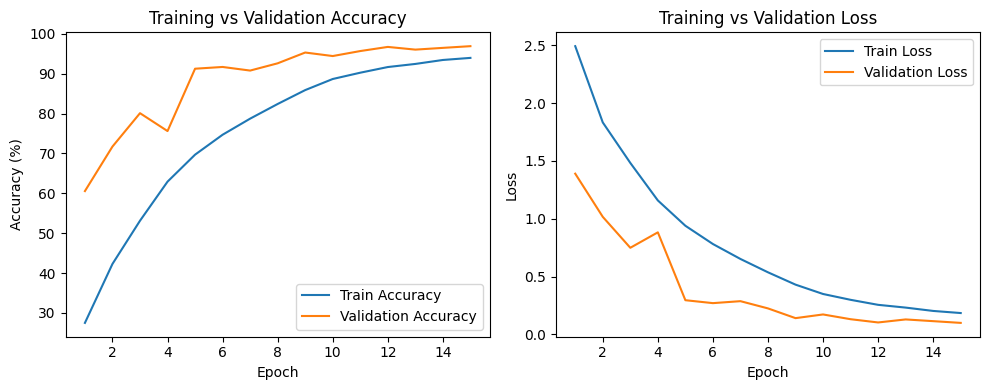

In [ ]:
import os
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt

# ------------------------ Define Model ------------------------
class AdvancedPlantDiseaseCNN(nn.Module):
    def __init__(self, num_classes):
        super(AdvancedPlantDiseaseCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 16 * 16, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# ------------------------ Configuration ------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = 38
batch_size = 32
num_epochs = 15
patience = 5
learning_rate = 0.001

# ------------------------ Transforms ------------------------
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

# ------------------------ Load Data ------------------------
train_loader = DataLoader(
    datasets.ImageFolder(
        r"E:/final project/Dataset/New Plant Diseases Dataset/train",
        transform=transform
    ),
    batch_size=batch_size, shuffle=True
)

valid_loader = DataLoader(
    datasets.ImageFolder(
        r"E:/final project/Dataset/New Plant Diseases Dataset/valid",
        transform=transform
    ),
    batch_size=batch_size, shuffle=False
)

test_loader = DataLoader(
    datasets.ImageFolder(
        r"E:/final project/Dataset/New Plant Diseases Dataset/test_data",
        transform=transform
    ),
    batch_size=batch_size, shuffle=False
)

# ------------------------ Initialize Model ------------------------
model = AdvancedPlantDiseaseCNN(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2)

# ------------------------ Training ------------------------
train_acc_history, val_acc_history = [], []
train_loss_history, val_loss_history = [], []
best_val_acc = 0
counter = 0

for epoch in range(num_epochs):
    model.train()
    train_correct, train_total, train_loss = 0, 0, 0

    for images, labels in tqdm(train_loader, desc=f"Training Epoch {epoch+1}"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        train_correct += (preds == labels).sum().item()
        train_total += labels.size(0)

    avg_train_loss = train_loss / len(train_loader)
    train_acc = 100 * train_correct / train_total

    model.eval()
    val_correct, val_total, val_loss = 0, 0, 0
    with torch.no_grad():
        for images, labels in tqdm(valid_loader, desc=f"Validating Epoch {epoch+1}"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    avg_val_loss = val_loss / len(valid_loader)
    val_acc = 100 * val_correct / val_total

    scheduler.step(avg_val_loss)

    print(f"\n📘 Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.2f}% | "
          f"Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.2f}%")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_custom_cnn_3.pth")
        print("✅ New best model saved.")
        counter = 0
    else:
        counter += 1
        print(f"⏳ No improvement. Patience counter: {counter}/{patience}")
        if counter >= patience:
            print("⛔ Early stopping triggered.")
            break

    train_acc_history.append(train_acc)
    val_acc_history.append(val_acc)
    train_loss_history.append(avg_train_loss)
    val_loss_history.append(avg_val_loss)

# ------------------------ Test Evaluation ------------------------
print("\n🔍 Evaluating best model on test set...")
model.load_state_dict(torch.load("best_custom_cnn_3.pth"))
model.eval()

test_correct, test_total, test_loss = 0, 0, 0
with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Testing"):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        test_correct += (preds == labels).sum().item()
        test_total += labels.size(0)

avg_test_loss = test_loss / len(test_loader)
test_acc = 100 * test_correct / test_total
print(f"\n🧪 Test Accuracy: {test_acc:.2f}% | Test Loss: {avg_test_loss:.4f}")

# ------------------------ Accuracy & Loss Plots ------------------------
epochs = range(1, len(train_acc_history) + 1)

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc_history, label="Train Accuracy")
plt.plot(epochs, val_acc_history, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Training vs Validation Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss_history, label="Train Loss")
plt.plot(epochs, val_loss_history, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()

plt.tight_layout()
plt.show()


In [2]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm

# ------------------------ Define Model ------------------------
class AdvancedPlantDiseaseCNN(nn.Module):
    def __init__(self, num_classes):
        super(AdvancedPlantDiseaseCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 16 * 16, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# ------------------------ Configuration ------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = 38
batch_size = 32
model_path = "best_custom_cnn_3.pth"

# ------------------------ Load Test Data ------------------------
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

test_loader = DataLoader(
    datasets.ImageFolder(
        r"E:/final project/Dataset/New Plant Diseases Dataset/test_data",
        transform=transform
    ),
    batch_size=batch_size, shuffle=False
)

# ------------------------ Load Model ------------------------
model = AdvancedPlantDiseaseCNN(num_classes=num_classes).to(device)
model.load_state_dict(torch.load(model_path))
model.eval()

# ------------------------ Evaluate ------------------------
criterion = nn.CrossEntropyLoss()
test_correct, test_total, test_loss = 0, 0, 0

print("\n🔍 Evaluating best model on test set...")
with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Testing"):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        test_correct += (preds == labels).sum().item()
        test_total += labels.size(0)

avg_test_loss = test_loss / len(test_loader)
test_acc = 100 * test_correct / test_total

print(f"\n🧪 Test Accuracy: {test_acc:.2f}% | Test Loss: {avg_test_loss:.4f}")



🔍 Evaluating best model on test set...


Testing: 100%|██████████| 3/3 [00:03<00:00,  1.05s/it]


🧪 Test Accuracy: 100.00% | Test Loss: 0.0036


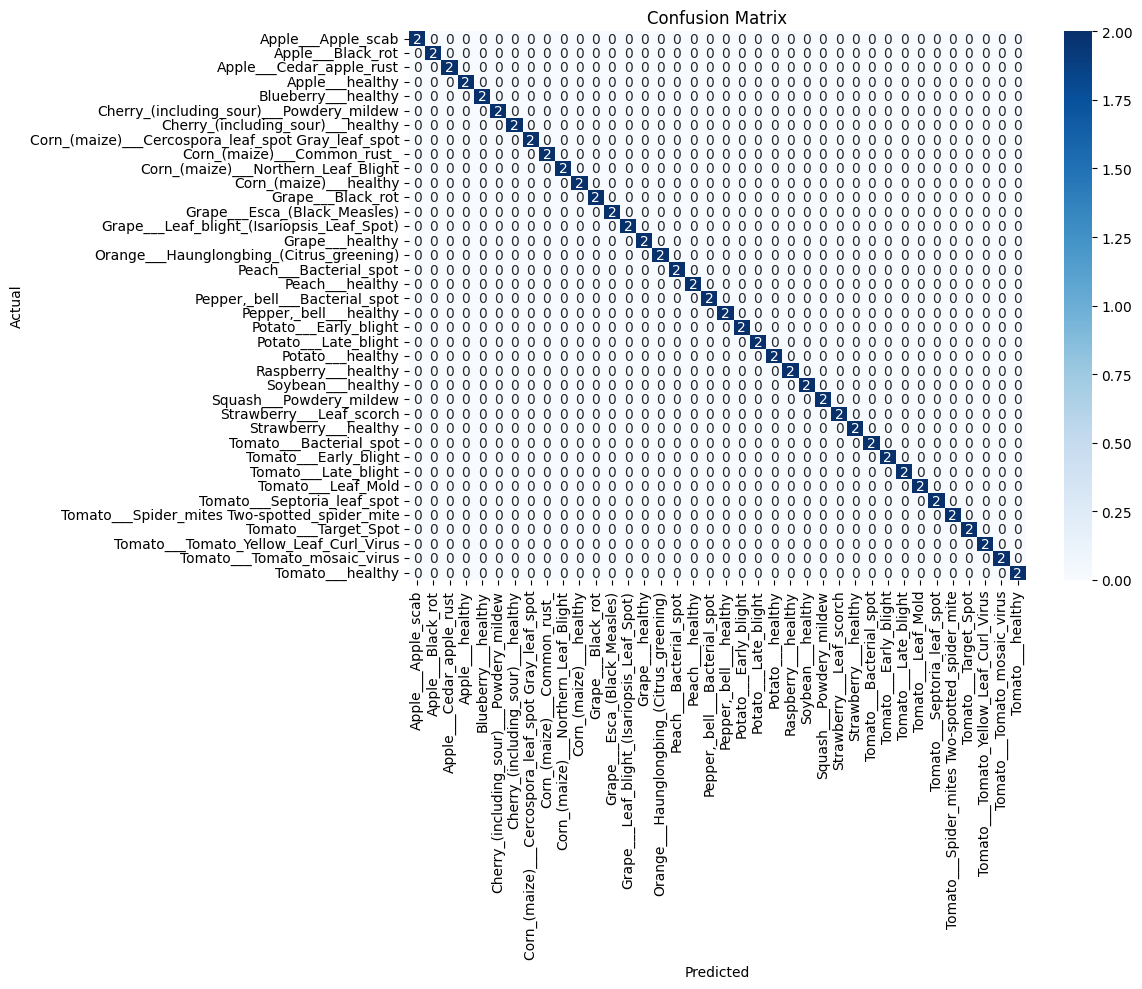


📝 Classification Report:

                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       1.00      1.00      1.00         2
                                 Apple___Black_rot       1.00      1.00      1.00         2
                          Apple___Cedar_apple_rust       1.00      1.00      1.00         2
                                   Apple___healthy       1.00      1.00      1.00         2
                               Blueberry___healthy       1.00      1.00      1.00         2
          Cherry_(including_sour)___Powdery_mildew       1.00      1.00      1.00         2
                 Cherry_(including_sour)___healthy       1.00      1.00      1.00         2
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       1.00      1.00      1.00         2
                       Corn_(maize)___Common_rust_       1.00      1.00      1.00         2
               Corn_(maize)___Northern_Leaf_Blight  

In [3]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Get class names from test dataset
class_names = test_loader.dataset.classes

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Classification report
print("\n📝 Classification Report:\n")
print(classification_report(all_labels, all_preds, target_names=class_names))


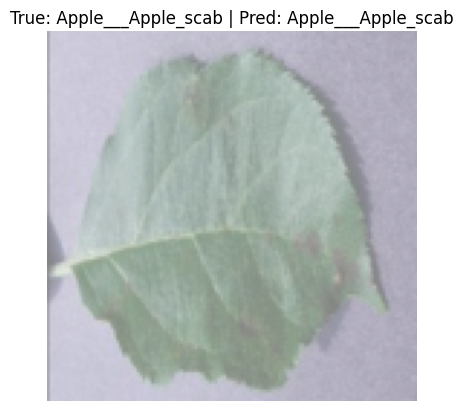

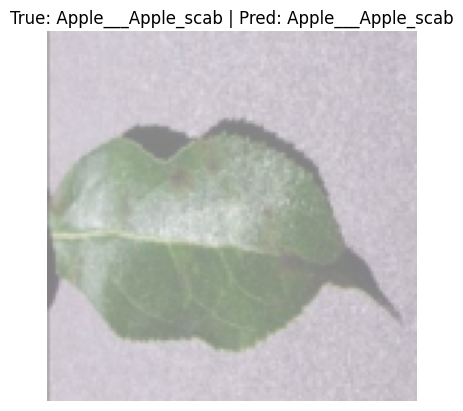

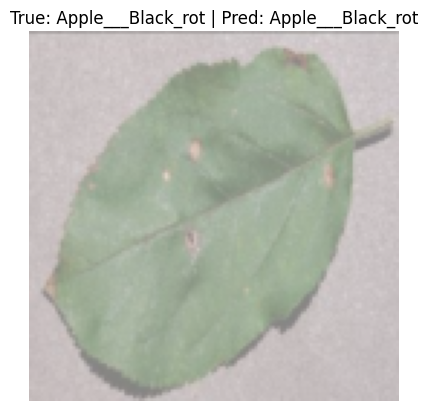

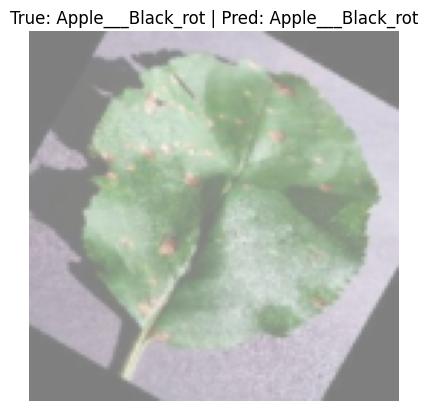

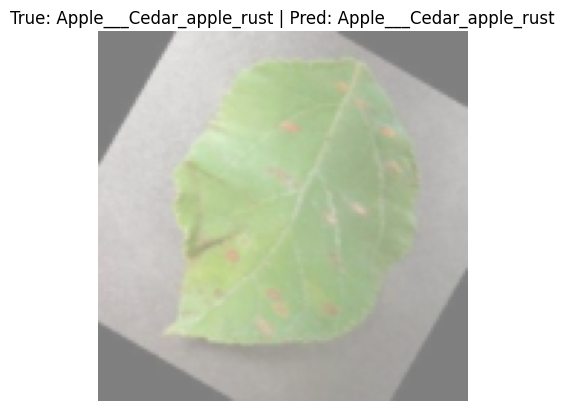

In [4]:
def imshow(img, title):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.axis('off')
    plt.show()

# Show 5 random predictions
model.eval()
with torch.no_grad():
    dataiter = iter(test_loader)
    images, labels = next(dataiter)
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    _, preds = torch.max(outputs, 1)

    for i in range(5):
        imshow(images[i].cpu(), title=f"True: {class_names[labels[i]]} | Pred: {class_names[preds[i]]}")


In [5]:
import cv2
import numpy as np

# Hook functions to capture gradients and activations
gradients = None
activations = None

def save_gradient(module, grad_input, grad_output):
    global gradients
    gradients = grad_output[0]

def save_activation(module, input, output):
    global activations
    activations = output

# Register hooks on last conv layer
last_conv_layer = model.features[6]
last_conv_layer.register_forward_hook(save_activation)
last_conv_layer.register_backward_hook(save_gradient)

def generate_gradcam(image_tensor, class_idx):
    model.zero_grad()
    output = model(image_tensor)
    class_score = output[0, class_idx]
    class_score.backward()

    # Global average pooling of gradients
    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
    activations_np = activations[0].detach().cpu().numpy()

    for i in range(activations_np.shape[0]):
        activations_np[i, :, :] *= pooled_gradients[i].cpu().numpy()

    heatmap = np.mean(activations_np, axis=0)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)

    return heatmap


In [8]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

def show_gradcam(image_tensor, true_label, pred_label, class_names):
    # Generate Grad-CAM heatmap
    heatmap = generate_gradcam(image_tensor, pred_label)

    # Convert image tensor to numpy for visualization
    img = image_tensor.squeeze().detach().permute(1, 2, 0).cpu().numpy()
    img = np.clip(img, 0, 1)  # ensure pixel values are in [0,1]

    # Resize heatmap to match image size
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

    # Apply colormap to heatmap
    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
    heatmap_colored = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB) / 255.0

    # Superimpose heatmap on image
    superimposed_img = 0.4 * heatmap_colored + 0.6 * img

    # Plot
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 3, 1)
    plt.title("Original Image")
    plt.imshow(img)
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title("Grad-CAM Heatmap")
    plt.imshow(heatmap, cmap='jet')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title(f"Prediction: {class_names[pred_label]}\nTrue: {class_names[true_label]}")
    plt.imshow(superimposed_img)
    plt.axis('off')

    plt.tight_layout()
    plt.show()


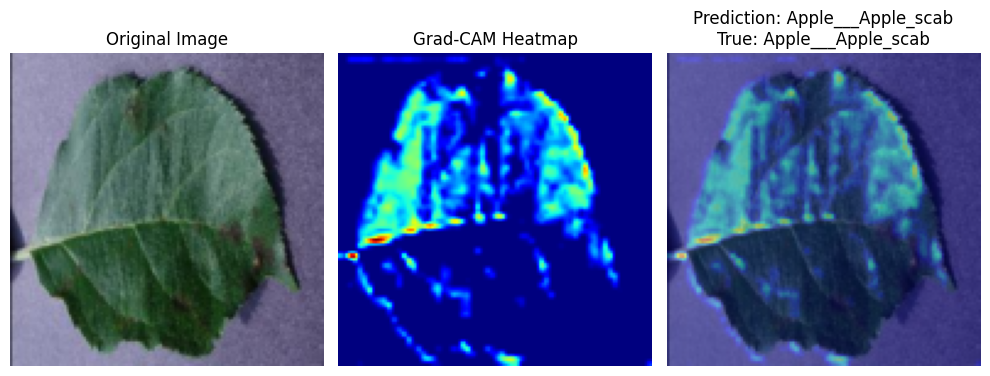

In [9]:
model.eval()
with torch.no_grad():
    dataiter = iter(test_loader)
    images, labels = next(dataiter)

# Enable gradient tracking for 1 image
image = images[0].unsqueeze(0).to(device)
image.requires_grad = True

# Forward pass and prediction
output = model(image)
_, pred_label = torch.max(output, 1)

# Visualize
show_gradcam(image, true_label=labels[0], pred_label=pred_label.item(), class_names=class_names)


##Comparison of pretrained models 

In [ ]:
import torch
import torch.nn as nn
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
import os

# --------------------- Configuration ---------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = 38
batch_size = 32
num_epochs = 5
learning_rate = 0.001

# --------------------- Transforms ---------------------
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# --------------------- Data Loaders ---------------------
data_dir = "E:/final project/Dataset/New Plant Diseases Dataset"
train_loader = DataLoader(datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=transform),
                          batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(datasets.ImageFolder(os.path.join(data_dir, 'valid'), transform=transform),
                          batch_size=batch_size, shuffle=False)
test_loader = DataLoader(datasets.ImageFolder(os.path.join(data_dir, 'test_data'), transform=transform),
                         batch_size=batch_size, shuffle=False)

# --------------------- Model Loader ---------------------
def load_model(name):
    if name == "resnet50":
        model = models.resnet50(pretrained=True)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
    elif name == "efficientnet_b0":
        model = models.efficientnet_b0(pretrained=True)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    elif name == "densenet121":
        model = models.densenet121(pretrained=True)
        model.classifier = nn.Linear(model.classifier.in_features, num_classes)
    else:
        raise ValueError("Unsupported model")
    return model.to(device)

# --------------------- Training Loop ---------------------
def train_model(model, optimizer, criterion, scheduler=None):
    best_val_acc = 0
    for epoch in range(num_epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1} Training"):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_acc = 100 * correct / total
        val_acc, val_loss = evaluate_model(model, valid_loader, criterion)
        if scheduler:
            scheduler.step(val_loss)

        print(f"Epoch {epoch+1}: Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}% | Val Loss: {val_loss:.4f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), f"best_{model.__class__.__name__}.pth")
            print("✅ New best model saved.")

# --------------------- Evaluation Function ---------------------
def evaluate_model(model, dataloader, criterion):
    model.eval()
    loss_total, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss_total += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return 100 * correct / total, loss_total / len(dataloader)

# --------------------- Run Training for All Models ---------------------
model_names = ["resnet50", "efficientnet_b0", "densenet121"]
results = {}

for model_name in model_names:
    print(f"\n🚀 Training {model_name}...")
    model = load_model(model_name)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2)
    train_model(model, optimizer, criterion, scheduler)
    
    model.load_state_dict(torch.load(f"best_{model.__class__.__name__}.pth"))
    test_acc, test_loss = evaluate_model(model, test_loader, criterion)
    results[model_name] = (test_acc, test_loss)
    print(f"🧪 Test Accuracy for {model_name}: {test_acc:.2f}% | Loss: {test_loss:.4f}")

# --------------------- Comparison Plot ---------------------
labels = list(results.keys())
values = [results[m][0] for m in labels]

plt.bar(labels, values, color=['blue', 'green', 'orange'])
plt.title("Test Accuracy Comparison")
plt.ylabel("Accuracy (%)")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()



🚀 Training resnet50...


c:\Users\nrama\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\nrama\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\nrama/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:20<00:00, 4.92MB/s]
Epoch 1 Training:  90%|████████▉ | 1969/2197 [9:03:26<32:13:17, 508.76s/it]  

In [10]:
import os

root_dirs = [
    r"E:/final project/Dataset/New Plant Diseases Dataset/train",
    r"E:/final project/Dataset/New Plant Diseases Dataset/valid",
    r"E:/final project/Dataset/New Plant Diseases Dataset/test/organized"
]

for path in root_dirs:
    print(f"\nInspecting: {path}")
    classes = [d for d in os.listdir(path) if os.path.isdir(os.path.join(path, d))]
    print(f"Number of classes: {len(classes)}")
    for c in classes[:3]:  # print first 3 class names
        print(f"  - {c}")



Inspecting: E:/final project/Dataset/New Plant Diseases Dataset/train
Number of classes: 38
  - Apple___Apple_scab
  - Apple___Black_rot
  - Apple___Cedar_apple_rust

Inspecting: E:/final project/Dataset/New Plant Diseases Dataset/valid
Number of classes: 38
  - Apple___Apple_scab
  - Apple___Black_rot
  - Apple___Cedar_apple_rust

Inspecting: E:/final project/Dataset/New Plant Diseases Dataset/test/organized
Number of classes: 8
  - AppleCedarRustJPG
  - AppleScabJPG
  - CornCommonRustJPG


In [11]:
folder_mapping = {
    "AppleCedarRustJPG": "Apple___Cedar_apple_rust",
    "AppleScabJPG": "Apple___Apple_scab",
    "CornCommonRustJPG": "Corn___Common_rust",
    "CornGrayLeafSpotJPG": "Corn___Gray_leaf_spot",
    "GrapeEscaJPG": "Grape___Esca_(Black_Measles)",
    "PotatoEarlyBlightJPG": "Potato___Early_blight",
    "TomatoLeafMoldJPG": "Tomato___Leaf_Mold",
    "TomatoTargetSpotJPG": "Tomato___Target_Spot",
}


In [12]:
import os

# Path to test directory
test_dir = r"E:/final project/Dataset/New Plant Diseases Dataset/test/organized"

# Mapping of current to correct folder names
folder_mapping = {
    "AppleCedarRustJPG": "Apple___Cedar_apple_rust",
    "AppleScabJPG": "Apple___Apple_scab",
    "CornCommonRustJPG": "Corn___Common_rust",
    "CornGrayLeafSpotJPG": "Corn___Gray_leaf_spot",
    "GrapeEscaJPG": "Grape___Esca_(Black_Measles)",
    "PotatoEarlyBlightJPG": "Potato___Early_blight",
    "TomatoLeafMoldJPG": "Tomato___Leaf_Mold",
    "TomatoTargetSpotJPG": "Tomato___Target_Spot",
}

# Apply renaming
for wrong_name, correct_name in folder_mapping.items():
    src = os.path.join(test_dir, wrong_name)
    dst = os.path.join(test_dir, correct_name)
    if os.path.exists(src):
        os.rename(src, dst)
        print(f"✅ Renamed: {wrong_name} ➜ {correct_name}")
    else:
        print(f"❌ Not found: {wrong_name}")


✅ Renamed: AppleCedarRustJPG ➜ Apple___Cedar_apple_rust
✅ Renamed: AppleScabJPG ➜ Apple___Apple_scab
✅ Renamed: CornCommonRustJPG ➜ Corn___Common_rust
❌ Not found: CornGrayLeafSpotJPG
❌ Not found: GrapeEscaJPG
✅ Renamed: PotatoEarlyBlightJPG ➜ Potato___Early_blight
❌ Not found: TomatoLeafMoldJPG
❌ Not found: TomatoTargetSpotJPG
